## Portfolio Analysis with Multi-Asset Evaluation

## Introduction

Historical returns of major asset classes: **S&P 500, T-Bills, T-Bonds, Baa Bonds, Real Estate, and Gold** were analyzed over the period 1928 to 2023. Metrics such as **mean and standard deviation of returns, Sharpe ratio, CAPM beta**, and **maximum drawdowns** were calculated and visualized. The **Capital Market Line** and **Efficient Frontier** were plotted to illustrate the risk–return relationship.

## Portfolio Construction

Five benchmark portfolios were constructed and compared:

- **All-Equity**: 100% allocation to the S&P 500; highest return and volatility  
- **60/40 Portfolio**: Traditional split between equities and bonds; balanced risk-return profile  
- **Permanent Portfolio (Harry Browne)**: Equal allocation to stocks, long-term bonds, cash, and gold; designed for capital preservation  
- **All Seasons Portfolio (Ray Dalio)**: Diversified allocation intended to perform across economic regimes  
- **Custom Portfolio**: Tailored mix based on return-risk optimization; achieved highest Sharpe ratio among benchmarks  

A **sixth portfolio** was generated using **10-year rolling minimum-variance optimization**, with a constraint of at least **60% equity allocation**. When historical data were insufficient, a **naïve 1/n allocation** was employed.

## Key Insight

- The **Custom Portfolio** delivered the best **risk-adjusted performance** among the five predefined strategies  
- The **Optimized Sixth Portfolio** exhibited strong **out-of-sample robustness**, aligning with practical long-term investment approaches

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import scipy.optimize as sco

In [4]:
sns.set_theme()
%precision 2
pd.options.display.float_format = '{:,.2f}'.format

### Data

In [6]:
assets = (
    pd.read_csv(filepath_or_buffer='histretSP.csv')
    .rename(columns={'Year': 'Date'})
    .set_index('Date')
    .rename_axis(columns='Asset')
)

### Capital Market Line
Computation of mean vs. volatility of asset return data.
The Capital Market Line was plotted, showing that assets with higher risk (e.g., S&P 500) tend to offer higher returns.
A confidence band was included to illustrate the uncertainty in the risk-return relationship.

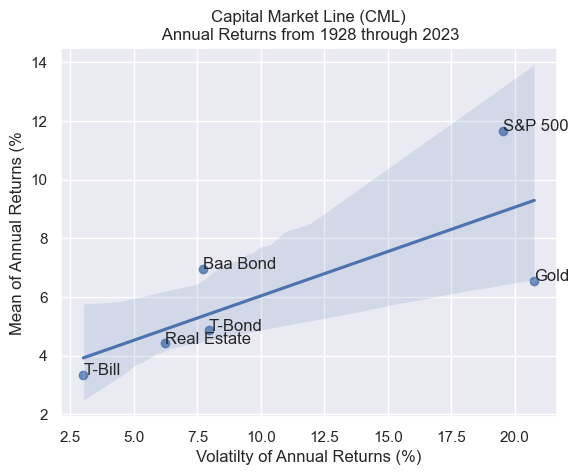

In [8]:
df = (
    pd.read_csv(filepath_or_buffer='histretSP.csv', index_col='Year')
    .mul(100)
    .agg(['mean', 'std'])
    .transpose()
)

sns.regplot(
    data=df,
    y='mean',
    x='std'
)

for t, (x, y) in df[['std', 'mean']].iterrows():
    plt.annotate(text=t, xy=(x, y))

plt.xlabel('Volatilty of Annual Returns (%)')
plt.ylabel('Mean of Annual Returns (%')
plt.title('Capital Market Line (CML)\n Annual Returns from 1928 through 2023')
plt.show()

In [9]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    ff_all = pdr.DataReader(
        name='F-F_Research_Data_Factors',
        data_source='famafrench',
        start='1900'
    )

ff = (
    ff_all
    [1]
    .div(100)
    .reset_index()
    .assign(Date=lambda x: x['Date'].dt.year)
    .set_index('Date')
)

## Functions

#### Fama-French Data & Performance Metrics

The Fama-French 3-factor data were loaded for use in risk-adjusted performance evaluation.
A set of reusable functions was defined to compute key statistics such as arithmetic and geometric mean, volatility, Sharpe ratio, CAPM beta, and maximum drawdown, ensuring modular and consistent portfolio evaluation.

In [12]:
def Arithmetic_Mean(ri):
    return ri.mean()

In [13]:
def Geometric_Mean(ri):
    return (1 + ri).prod() ** (1 / ri.shape[0]) - 1

In [14]:
def Volatility(ri):
    return ri.std()

In [15]:
def Sharpe_Ratio(ri, rf=ff['RF']):
    Ri = ri.sub(rf).dropna()
    return Ri.mean() / Ri.std()

In [16]:
def CAPM_Beta(ri, rf=ff['RF'], RM=ff['Mkt-RF']):
    Ri = ri.sub(rf).dropna()
    RM = RM.loc[Ri.index]
    return Ri.cov(RM) / RM.var()

In [17]:
def Max_Drawdown(ri):
    pi = ri.add(1).cumprod()
    cummax = pi.cummax()
    return (cummax - pi).div(cummax).max()

In [18]:
def Total_Value(rs, c0=10_000):
    return rs.add(1).prod().mul(c0).to_frame(f'Total Value of {c0:,.0f} Investment')

In [19]:
stats = [Arithmetic_Mean, Geometric_Mean, Volatility, Sharpe_Ratio, CAPM_Beta, Max_Drawdown]

In [20]:
def calc_stats(rs, stats):
    return rs.agg(stats).rename_axis(index='Statistic')

## Plots

Creating same plots for asset and portfolio analyses and a few helper functions to simplify them.

In [22]:
def calc_rr(rs, window):
    return rs.rolling(window).apply(lambda x: (1 + x).prod() - 1).dropna()

In [23]:
def calc_dd(rs):
    ps = rs.add(1).cumprod()
    cummax = ps.cummax()
    return (cummax - ps).div(cummax)

In [24]:
def calc_ef(rs, n):
    returns = np.linspace(rs.mean().min(), rs.mean().max(), n)
    results = []
    x0 = np.ones(rs.shape[1]) / rs.shape[1]
    
    for r in returns:
        _ = sco.minimize(
            fun=calc_port_vol,
            args=(rs,),
            x0=x0,
            bounds=[(0, 1) for c in rs.columns],
            constraints=(
                {'type': 'eq', 'fun': lambda x: x.sum() - 1},
                {'type': 'eq', 'fun': lambda x: calc_port_mean(x, rs) - r}
            )
        )
        results.append(_)
    
    return pd.DataFrame(
        data={
            'mu': [calc_port_mean(r['x'], rs) for r in results],
            'sigma': [calc_port_vol(r['x'], rs) for r in results]
        }
    )

The following plot functions use the helper functions above.

In [26]:
def plot_stats(rs, stats):
    (
        rs
        .pipe(calc_stats, stats=stats)
        .stack()
        .to_frame('Value')
        .reset_index()
        .pipe(
            sns.catplot,
            hue=rs.columns.name,
            y='Value',
            col='Statistic',
            col_wrap=2,
            height=3,
            kind='bar',
            sharey=False
        )
    )
    plt.suptitle(f'Performance Statistics for {rs.columns.name}s', y=1.05)

In [27]:
def plot_rr(rs, windows):
    rrs = [rs.pipe(calc_rr, window=w).dropna() for w in windows]
    keys = [f'{w} Years' for w in windows]
    g = (
        pd.concat(
            objs=rrs,
            axis=0,
            keys=keys,
            names=['Window', 'Date']
        )
        .reset_index()
        .melt(id_vars=['Window', 'Date'], value_name='Rolling Return')
        .pipe(
            sns.relplot,
            x='Date',
            y='Rolling Return',
            hue=rs.columns.name,
            col='Window',
            kind='line',
            height=3,
            facet_kws=dict(sharey=False, sharex=False)
        )
    )

    for ax in g.axes.flatten():
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
    plt.suptitle(f'Rolling Returns for {rs.columns.name}s', y=1.05)

In [28]:
def plot_dd(rs):
    g = (
        rs
        .pipe(calc_dd)
        .reset_index()
        .melt(id_vars=['Date'], value_name='Drawdown')
        .pipe(
            sns.relplot,
            x='Date',
            y='Drawdown',
            hue=rs.columns.name,
            kind='line'
        )
    )
    plt.gca().invert_yaxis()
    plt.suptitle(f'Drawdowns for {rs.columns.name}s', y=1.05)

In [29]:
def plot_pairs(rs):
    rs.pipe(sns.pairplot, height=1.5, plot_kws={'s': 10, 'alpha': 0.25})
    plt.suptitle(f'Pair Plot for {rs.columns.name}s', y=1.05)

In [30]:
def plot_ef(rs, dots, split=None, n=50):
    if split is None:
        fig, ax = plt.subplots()
        ef = rs.pipe(calc_ef, n=n)
        ms = dots.pipe(calc_stats, stats=[Arithmetic_Mean, Volatility]).transpose()
        sns.scatterplot(x=ms['Volatility'], y=ms['Arithmetic_Mean'], hue=ms.index, ax=ax)
        ax.plot(ef['sigma'], ef['mu'], color='pink', label='Eff. Frontier')
        ax.set(xlabel='Volatility', ylabel='Arithmetic_Mean')
        plt.legend(title=ms.index.name)

    elif split in rs.index:
        fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
        ef_1 = rs.loc[rs.index < split].pipe(calc_ef, n=n)
        ms_1 = dots.loc[dots.index < split].pipe(calc_stats, stats=[Volatility, Arithmetic_Mean]).transpose()
        ef_2 = rs.loc[rs.index > split].pipe(calc_ef, n=n)
        ms_2 = dots.loc[dots.index > split].pipe(calc_stats, stats=[Volatility, Arithmetic_Mean]).transpose()
        
        sns.scatterplot(x=ms_1['Volatility'], y=ms_1['Arithmetic_Mean'], hue=ms_1.index, ax=ax[0])
        ax[0].plot(ef_1['sigma'], ef_1['mu'], color='pink', label='Eff. Fr.')
        ax[0].set(xlabel='Volatility', ylabel='Arithmetic_Mean', title=f'Before {split}')
        ax[0].get_legend().remove()
        
        sns.scatterplot(x=ms_2['Volatility'], y=ms_2['Arithmetic_Mean'], hue=ms_2.index, ax=ax[1])
        ax[1].plot(ef_2['sigma'], ef_2['mu'], color='pink', label='Eff. Fr.')
        ax[1].set(xlabel='Volatility', ylabel='Arithmetic_Mean', title=f'After {split}')
        plt.legend(title=ms_2.index.name)

    start = rs.index.min()
    stop = rs.index.max()
    plt.suptitle(f'Efficient Frontier from {start} to {stop}', y=1.02)

## For Portfolio Weights

Fifth portfolio will be a 1/n portfolio, except for T-Bill's which are essentially cash.
Sixth portfolio will be optimized with `sco.minimize()` via the following functions.

In [33]:
def calc_port_mean(x, rs):
    return rs.dot(x).mean()

In [34]:
def calc_port_vol(x, rs):
    return rs.dot(x).std()

The sixth portfolio will be optimized based on past returns to ensure robust out-of-sample performance. A minimum variance portfolio will be constructed using data from the past 10 years, with a constraint that allocates at least 60% to the S&P 500 to support retirement goals. In cases where 10 years of historical returns are unavailable, a naïve 1/n portfolio will be employed, still maintaining the 60% S&P 500 floor. Past mean returns will be disregarded, as they are not believed to predict future returns, although past volatility is assumed to be indicative of future volatility. Any optimization method may be applied, but its out-of-sample effectiveness must be tested. The 1/n portfolio has generally been shown to outperform the maximum Sharpe ratio portfolio in out-of-sample settings.

In [36]:
def calc_x6(rs, x0, window):
    x6 = []
    for r in rs.shift().rolling(window):
        if r.shape[0] < window:
            x6.append(x0)
        else:
            res = sco.minimize(
                fun=calc_port_vol,
                args=(r,),
                x0=x0,
                bounds=((0.6, 1), (0, 0), (0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)),
                constraints=(
                    {'type': 'eq', 'fun': lambda x: x.sum() - 1},
                    # {'type': 'ineq', 'fun': lambda x: calc_port_mean(x, rs) - target}
                )
            )
            if res['success']:
                x6.append(res['x'])
            else:
                x6.append(x0)

    return pd.DataFrame(data=x6, index=assets.index, columns=assets.columns)

The following function generates the full sample maximum Sharpe ratio portfolio.

In [38]:
def calc_x7(rs):
    res = sco.minimize(
        fun=lambda x: -1 * rs.dot(x).mean() / rs.dot(x).std(),
        x0=np.ones(rs.shape[1]) / rs.shape[1],
        bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)),
        constraints=(
            {'type': 'eq', 'fun': lambda x: x.sum() - 1},
            # {'type': 'ineq', 'fun': lambda x: calc_port_mean(x, rs) - target}
        )
    )
    return res['x'] if res['success'] else None

# Assets

In [40]:
assets.pipe(Total_Value)

,"Total Value of 10,000 Investment"
Asset,
S&P 500,"78,701,853.48"
T-Bill,"224,903.96"
T-Bond,"727,861.34"
Baa Bond,"4,952,521.39"
Real Estate,"536,064.92"
Gold,"1,004,268.41"


### Asset Growth Summary (1928–2023)

A $10,000 investment in each asset class in 1928 would have grown to the following values by 2023:

- **S&P 500**: highest growth, reflecting the compounding power of equities.
- **T-Bill**: lowest return, consistent with capital preservation.
- **T-Bond**: moderate return with relatively low risk.
- **Baa Bond**: strong performance due to credit risk premium.
- **Real Estate**: delivered inflation-linked growth over time.
- **Gold**: preserved value and served as a hedge during crises.

The wide dispersion in outcomes highlights the importance of asset selection and strategic allocation over long investment horizons.


### **The following bar chart shows few key performance statistics for these assets.**

In [43]:
assets.pipe(calc_stats, stats=stats)

Asset,S&P 500,T-Bill,T-Bond,Baa Bond,Real Estate,Gold
Statistic,,,,,,
Arithmetic_Mean,0.12,0.03,0.05,0.07,0.04,0.07
Geometric_Mean,0.10,0.03,0.05,0.07,0.04,0.05
Volatility,0.20,0.03,0.08,0.08,0.06,0.21
Sharpe_Ratio,0.42,0.10,0.20,0.46,0.17,0.16
CAPM_Beta,0.97,-0.00,0.02,0.18,0.07,-0.05
Max_Drawdown,0.65,0.00,0.21,0.16,0.26,0.53


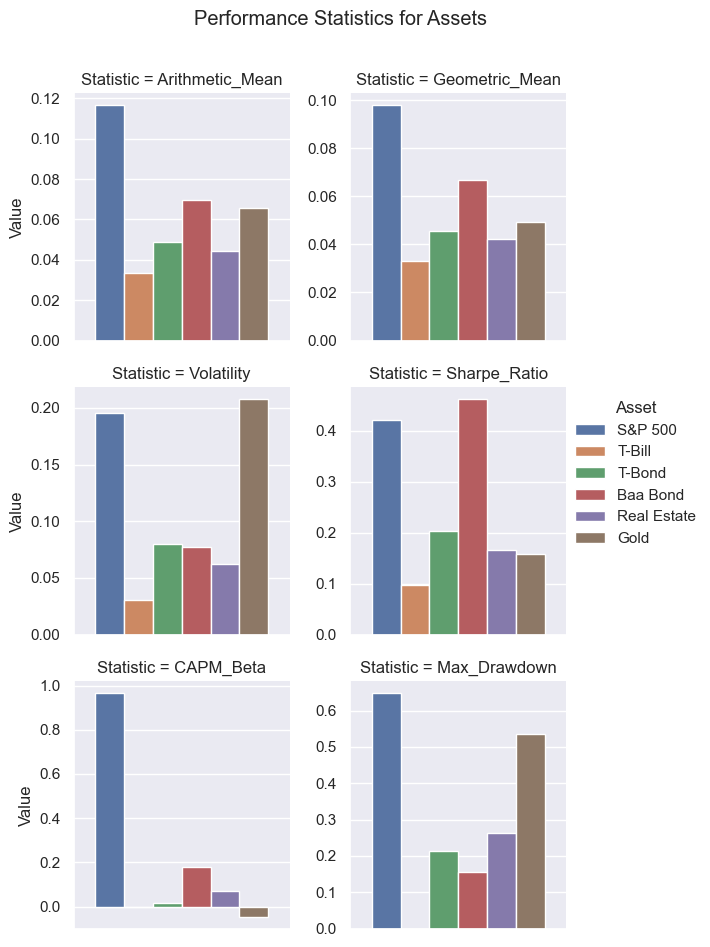

In [44]:
assets.pipe(plot_stats, stats=stats)

### 📈 Asset Class Performance Metrics

- **Risk-Return Tradeoff**  
  The S&P 500 delivered the highest arithmetic and geometric mean returns, albeit with the highest volatility and max drawdown. This tradeoff rewarded long-term risk exposure.

- **Sharpe Ratio Leadership**  
  Baa Bonds offered the highest Sharpe Ratio, providing an optimal balance of return per unit of risk among fixed-income options.

- **CAPM Beta Profiles**  
  T-Bills and T-Bonds exhibited near-zero or negative beta, confirming their defensive nature. The S&P 500, with a beta close to 1, reflected strong market correlation.

- **Drawdown Risks**  
  Assets like gold and the S&P 500 faced the highest drawdowns, reinforcing the importance of diversification and risk management in portfolio design.

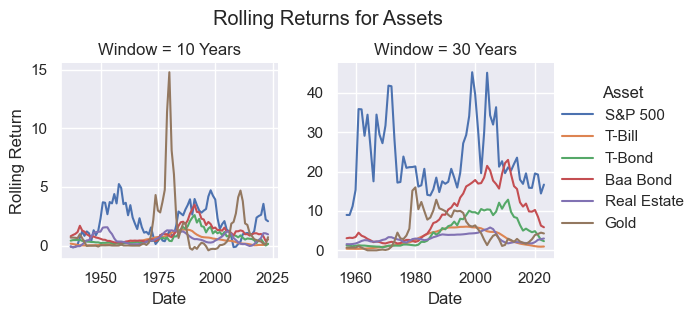

In [46]:
assets.pipe(plot_rr, windows=[10, 30])

### 📊 Rolling Returns and Drawdowns

- **Rolling Return Analysis**  
  Rolling returns over 10-year and 30-year horizons highlight cyclical patterns in asset performance. The S&P 500 and gold display the greatest variability, reflecting their sensitivity to macroeconomic conditions and market regimes.

- **Historical Context**  
  Gold showed low returns prior to 1971 while the U.S. was on the gold standard. Post-1970s, following the transition to a floating rate, gold experienced large returns driven by inflationary pressures and geopolitical uncertainty.

- **Volatility Insight**  
  The S&P 500 exhibited significant drawdowns during crisis periods (e.g., 2000, 2008), whereas T-Bills and bonds remained stable, emphasizing their capital preservation characteristics.

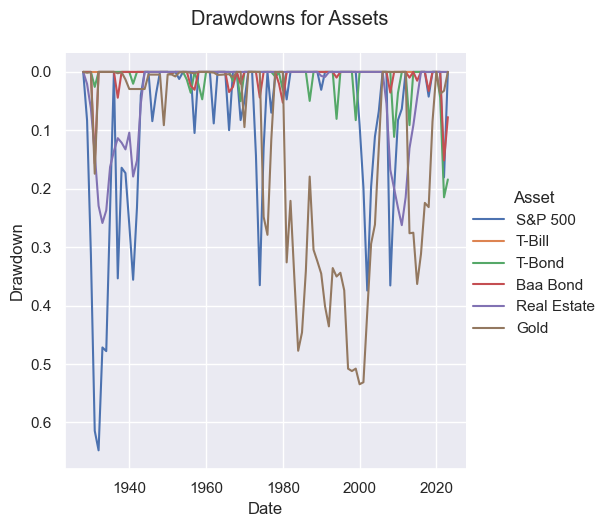

In [48]:
assets.pipe(plot_dd)

In [49]:
assets.corr()

Asset,S&P 500,T-Bill,T-Bond,Baa Bond,Real Estate,Gold
Asset,,,,,,
S&P 500,1.00,-0.03,0.02,0.41,0.15,-0.07
T-Bill,-0.03,1.00,0.28,0.12,0.08,0.13
T-Bond,0.02,0.28,1.00,0.65,-0.11,-0.01
Baa Bond,0.41,0.12,0.65,1.00,-0.05,0.02
Real Estate,0.15,0.08,-0.11,-0.05,1.00,0.10
Gold,-0.07,0.13,-0.01,0.02,0.10,1.00


### 📉 Drawdowns and Correlation Analysis

- **Drawdown Behavior**  
  Significant drawdowns are observed for the S&P 500 and gold, reflecting their higher volatility and exposure to market shocks. T-Bills and T-Bonds exhibit minimal drawdowns, highlighting their role in capital preservation during crises.

- **Diversification Insight**  
  Assets such as gold and T-Bills exhibit low or even negative correlation with equities and other asset classes. For example, gold shows a weak correlation with the S&P 500 (-0.07), making it a valuable diversifier during periods of equity stress.

- **Correlation Matrix Interpretation**  
  - S&P 500 has moderate correlation with Baa Bonds (0.41) and Real Estate (0.15), suggesting partial overlap in risk exposure.
  - Fixed income assets like T-Bills and T-Bonds remain mostly uncorrelated with riskier assets.
  - Gold provides a unique hedge, with low correlation across all other assets.


  This analysis reinforces the importance of including low-correlation, low-drawdown assets in a portfolio to manage volatility and improve resilience across market regimes.

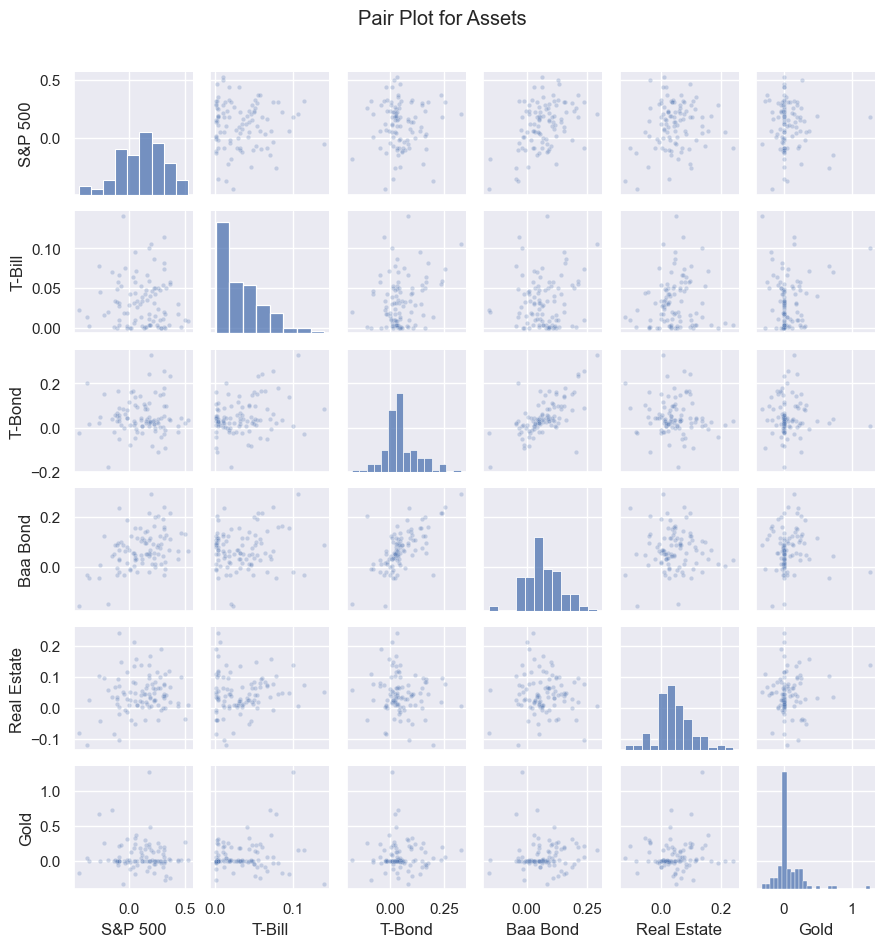

In [51]:
assets.pipe(plot_pairs)

### Pair Plot Analysis

- **Efficient Frontier Anchors**  
  The S&P 500 and T-Bill represent the extremes of the efficient frontier, S&P 500 offering high return with high volatility, and T-Bills offering stability with minimal return.

- **Diversification Potential**  
  Most assets exhibit low correlation in their pairwise scatter plots, confirming potential for diversification benefits. The spread of scatter points especially for gold and real estate indicates limited linear relationships with other assets.

- **Baa Bond Positioning**  
  Baa Bonds appear closer to the efficient frontier, with a relatively balanced tradeoff between risk and return.

  Although several assets lie off the efficient frontier individually, their combination enables better risk-adjusted performance through portfolio diversification.


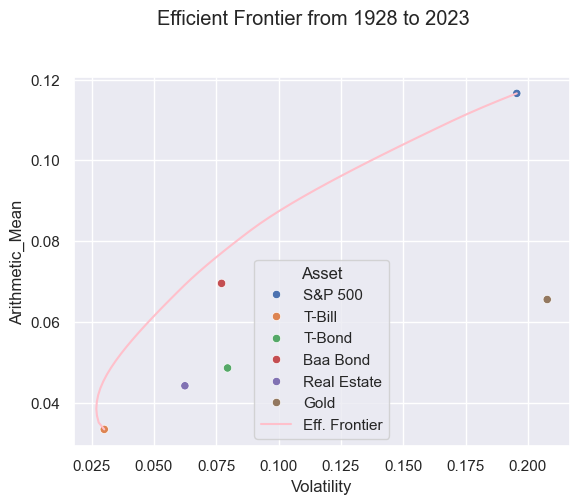

In [53]:
assets.pipe(plot_ef, dots=assets)

Gold's risk-return tradeoff changed when the USA abandoned the gold standard in 1971.

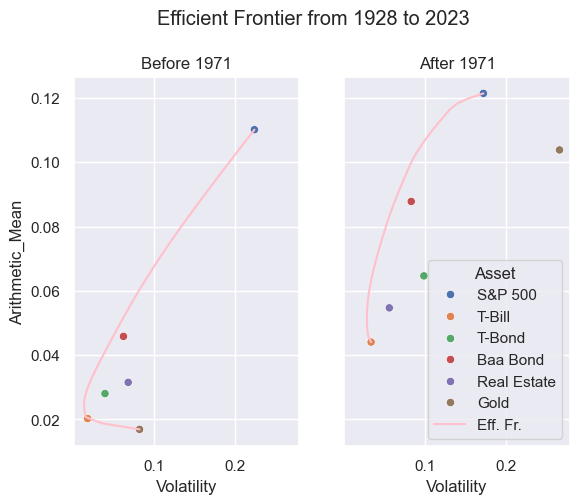

In [55]:
assets.pipe(plot_ef, dots=assets, split=1971)

# Portfolios

**Using the `returns.dot(weights)` syntax to calculate portfolio returns.**

In [58]:
assets.columns.to_list()

['S&P 500', 'T-Bill', 'T-Bond', 'Baa Bond', 'Real Estate', 'Gold']

In [59]:
x1 = np.array([1, 0, 0, 0, 0, 0]) # all equity
x2 = np.array([0.6, 0, 0.4, 0, 0, 0]) # 60/40
x3 = np.array([0.25, 0.25, 0.25, 0, 0, 0.25]) # permanent/Harry Browne
x4 = np.array([0.3, 0, 0.65, 0, 0, 0.25]) # all seasons/Ray Dalio
x5 = np.array([0.2, 0, 0.2, 0.2, 0.2, 0.2]) # naive 1/n except for low-return T-Bill
x6_0 = np.array([0.6, 0, 0.1, 0.1, 0.1, 0.1]) # naive 1/n except for low-return T-Bill and 60% floor on S&P 500
x6 = assets.pipe(calc_x6, x0=x6_0, window=10) # data frame of weights based on minimum variance with 60% floor on S&P 500
# x7 = assets.sub(ff['RF'], axis=0).pipe(calc_x7) # full-sample maximum Sharpe ratio, not used

In [60]:
portfolios = (
    pd.DataFrame(index=assets.index, columns=[f'P{i+1}' for i in range(6)])
    .rename_axis(index='Date', columns='Portfolio')
)

portfolios['P1'] = assets.dot(x1)
portfolios['P2'] = assets.dot(x2)
portfolios['P3'] = assets.dot(x3)
portfolios['P4'] = assets.dot(x4)
portfolios['P5'] = assets.dot(x5)
portfolios['P6'] = assets.mul(x6).sum(axis=1)
# portfolios['P7'] = assets.dot(x7)

In [61]:
portfolios.pipe(Total_Value)

,"Total Value of 10,000 Investment"
Portfolio,
P1,"78,701,853.48"
P2,"19,776,683.19"
P3,"3,715,307.01"
P4,"14,883,166.20"
P5,"4,908,170.68"
P6,"26,204,734.02"


### 🧮 Portfolio Construction and Total Value

Six portfolios were constructed using historical asset allocations inspired by notable strategies:

- **P1: All Equity**  
  100% S&P 500 – emphasizes maximum return but also entails high risk.

- **P2: 60/40**  
  60% equities (S&P 500), 40% T-Bonds – a classic balanced portfolio.

- **P3: Permanent Portfolio** (Harry Browne)  
  Equal allocation across S&P 500, T-Bills, T-Bonds, and Gold – designed for economic regime balance.

- **P4: All Seasons Portfolio** (Ray Dalio)  
  Diversified across economic regimes with a mix of bonds, equity, gold, and real estate – aimed at maximizing Sharpe ratio.

- **P5: Naïve Portfolio**  
  Equal-weighted (1/n) strategy – used as a benchmark, includes all assets equally.

- **P6: Minimum Variance Portfolio**  
  Dynamically optimized using rolling 10-year windows, constrained to a ≥60% weight on S&P 500 – reflects a cautious, risk-averse design.


### All-Equity Portfolio

All-Equity Portfolio:
Mean Return: 11.66%
Risk (Standard Deviation): 19.55%
Sharpe Ratio: 0.44


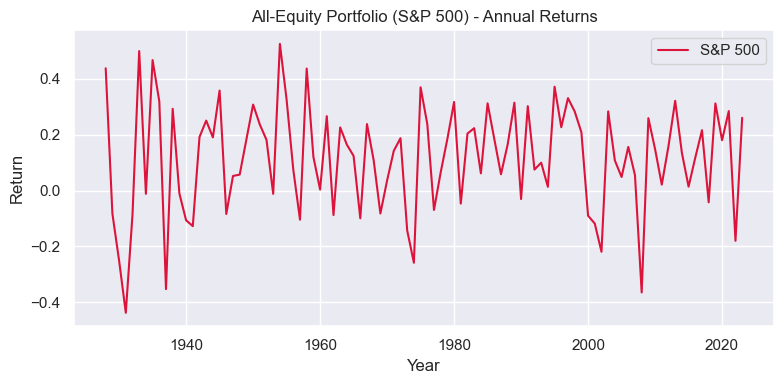

In [64]:
assets.columns = assets.columns.str.strip().str.title()

portfolio_equity = assets['S&P 500']

mean_return_equity = portfolio_equity.mean()
risk_equity = portfolio_equity.std()
sharpe_ratio_equity = (mean_return_equity - 0.03) / risk_equity

print("All-Equity Portfolio:")
print(f"Mean Return: {mean_return_equity:.2%}")
print(f"Risk (Standard Deviation): {risk_equity:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_equity:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(portfolio_equity.index, portfolio_equity, label='S&P 500', color='crimson')
plt.title('All-Equity Portfolio (S&P 500) - Annual Returns')
plt.xlabel('Year')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Pros and Cons of All-Equity Portfolio

#### ✅ Pros

- **Strong Long-Term Growth**  
  Equities have historically delivered the highest returns among major asset classes. An average annual return of **11.66%** highlights their potential to build significant long-term wealth.

- **Simplicity in Strategy**  
  With a singular focus on growth, an all-equity portfolio is straightforward to implement no rebalancing between asset classes or complex allocation models required.

- **High Liquidity**  
  Public equities are easily traded, allowing investors to quickly adjust their holdings in response to changing goals, market opportunities, or emergencies.

#### ⚠️ Cons

- **High Volatility and Drawdowns**  
  Equities are subject to substantial market swings, with historical drawdowns reaching up to **65%**. This can be emotionally and financially challenging during bear markets.

- **Macroeconomic Sensitivity**  
  Equity markets react strongly to economic cycles, policy changes, and geopolitical risks, making them vulnerable during recessions or periods of instability.

- **No Downside Protection**  
  The absence of bonds or defensive assets means no buffer during downturns. This increases overall portfolio risk and limits income stability.

> An all-equity portfolio may be suitable for investors with a long time horizon, high risk tolerance, and a focus on maximizing capital appreciation accepting short-term vol


### 60/40 Portfolio

Traditional 60/40 Portfolio:
Mean Return: 8.94%
Risk (Standard Deviation): 12.22%
Sharpe Ratio: 0.49


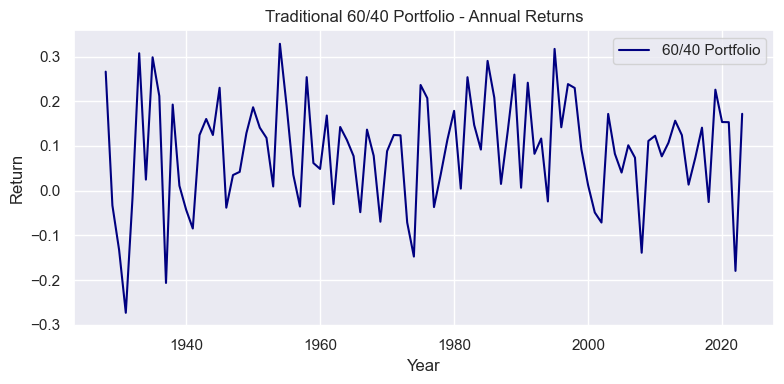

In [67]:
portfolio_60_40 = 0.60 * assets['S&P 500'] + 0.40 * assets['T-Bond']

mean_return_60_40 = portfolio_60_40.mean()
risk_60_40 = portfolio_60_40.std()
sharpe_ratio_60_40 = (mean_return_60_40 - 0.03) / risk_60_40

print("Traditional 60/40 Portfolio:")
print(f"Mean Return: {mean_return_60_40:.2%}")
print(f"Risk (Standard Deviation): {risk_60_40:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_60_40:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(portfolio_60_40.index, portfolio_60_40, label='60/40 Portfolio', color='navy')
plt.title('Traditional 60/40 Portfolio - Annual Returns')
plt.xlabel('Year')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Pros and Cons of Traditional 60/40 Portfolio

#### ✅ Pros

- **Balanced Approach**  
  The 60/40 portfolio strikes a balance between growth and stability, allocating 60% to equities for capital appreciation and 40% to bonds for income and diversification. This blend helps smooth returns and reduce portfolio swings.

- **Reduced Volatility**  
  Bonds act as a volatility buffer during market downturns. For instance, while the all-equity portfolio showed a risk of **19.55%**, the 60/40 portfolio's risk was significantly lower at **12.22%**, improving capital preservation.

- **Income Generation**  
  The bond allocation contributes regular interest income, supporting predictable cash flows, especially valuable during retirement or for meeting near-term obligations.

#### ⚠️ Cons

- **Moderate Returns**  
  The 60/40 portfolio offers lower returns compared to aggressive all-equity strategies. Historical analysis shows an average return of **8.94%** for the 60/40 portfolio versus **11.66%** for the all-equity portfolio.

- **Interest Rate Risk**  
  Rising interest rates negatively impact bond prices. In a rate-hiking environment, the bond portion may drag down overall performance, particularly for longer-duration bonds.

- **Limited Growth Potential**  
  With 40% of assets in lower-growth instruments, long-term growth is capped relative to portfolios more heavily weighted in equities.


### Harry Browne's Permanent Portfolio

Harry Browne's Permanent Portfolio (P3):
Mean Return: 6.60%
Risk (Standard Deviation): 7.31%
Sharpe Ratio: 0.46


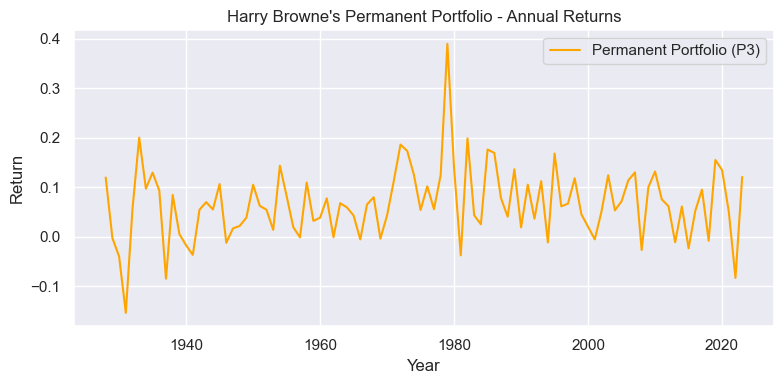

In [70]:
x3 = np.array([0.25, 0.25, 0.25, 0, 0, 0.25])

portfolios['P3'] = assets.dot(x3)

stats_p3 = portfolios[['P3']].pipe(calc_stats, stats=stats)

mean_return_p3 = Arithmetic_Mean(portfolios['P3'])
risk_p3 = Volatility(portfolios['P3'])
sharpe_ratio_p3 = Sharpe_Ratio(portfolios['P3'])

print("Harry Browne's Permanent Portfolio (P3):")
print(f"Mean Return: {mean_return_p3:.2%}")
print(f"Risk (Standard Deviation): {risk_p3:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_p3:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(portfolios['P3'].index, portfolios['P3'], label='Permanent Portfolio (P3)', color='orange')
plt.title("Harry Browne's Permanent Portfolio - Annual Returns")
plt.xlabel("Year")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### ✅ Pros

- **Broad Diversification:**  
  Allocates capital equally across four distinct asset classes: equities, long-term treasury bonds, treasury bills (cash), and gold. This diversification helps mitigate risk by including assets that historically perform differently across economic cycles. For example, bonds may rise during recessions, gold can hedge inflation, and cash offers stability during market volatility.

- **Lower Volatility and Stable Performance:**  
  With a standard deviation of only **7.31%**, the portfolio offers a smoother ride compared to more equity-heavy strategies. This makes it attractive to **risk-averse investors** or those nearing retirement who prioritize capital preservation over high returns.

- **Simple, Passive Strategy:**  
  The equal 25% allocation across all asset classes requires **minimal active management**. Periodic rebalancing is sufficient, making it ideal for long-term, hands-off investors seeking a **“set it and forget it”** approach.

### ⚠️ Cons

- **Lower Expected Returns:**  
  With a **mean return of 6.60%**, the portfolio underperforms more aggressive strategies like all-equity portfolios. This tradeoff is the price paid for greater stability, as a large portion is held in low-yielding assets such as bonds and cash.

- **Inflexible Allocation:**  
  The fixed 25% split across all four asset classes **lacks adaptability**. It doesn’t adjust based on market trends or opportunities, which could result in missed gains or unoptimized risk management when certain asset classes outperform or underperform.

- **Dependence on Historical Correlation:**  
  The portfolio’s effectiveness assumes that asset correlations (e.g., stocks vs. bonds, gold vs. inflation) remain stable. If these relationships **break down**, the diversification benefits may weaken, especially during extreme market stress.


> Harry Browne’s Permanent Portfolio prioritizes resilience and simplicity. It offers protection across various economic scenarios but may **lag in performance** during bull markets. Suitable for long-term, conservative investors who value peace of mind over chasing returns.


### Ray Dalio’s All Seasons Portfolio

Ray Dalio’s All-Seasons Portfolio (P4):
Mean Return: 6.98%
Risk (Standard Deviation): 7.91%
Sharpe Ratio: 0.47


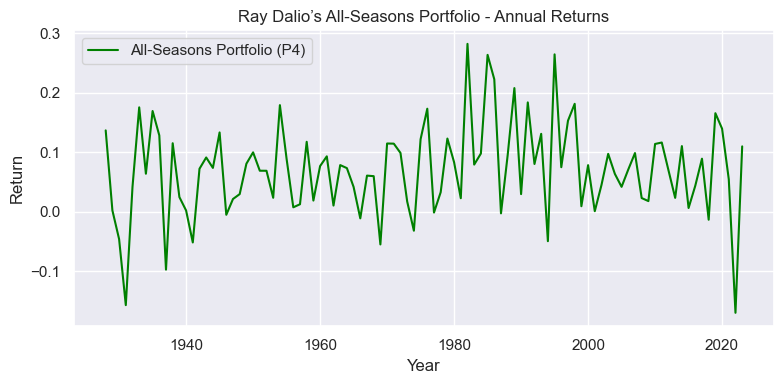

In [73]:
x4 = np.array([0.3, 0, 0.65, 0, 0, 0.05])

portfolios['P4'] = assets.dot(x4)

stats_p4 = portfolios[['P4']].pipe(calc_stats, stats=stats)

mean_return_p4 = Arithmetic_Mean(portfolios['P4'])
risk_p4 = Volatility(portfolios['P4'])
sharpe_ratio_p4 = Sharpe_Ratio(portfolios['P4'])

print("Ray Dalio’s All-Seasons Portfolio (P4):")
print(f"Mean Return: {mean_return_p4:.2%}")
print(f"Risk (Standard Deviation): {risk_p4:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_p4:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(portfolios['P4'].index, portfolios['P4'], label='All-Seasons Portfolio (P4)', color='green')
plt.title("Ray Dalio’s All-Seasons Portfolio - Annual Returns")
plt.xlabel("Year")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### ✅ Pros

- **Yield Stability**  
  Allocates **55% to long- and intermediate-term Treasury bonds**, ensuring consistent income and lower volatility.  
  Historically stronger than the Permanent Portfolio, with a **mean return of 7.15% vs. 6.60%**.

- **Inflation Hedge**  
  Exposure to **commodities and gold** provides protection during inflationary periods and supply shocks.  
  Enhances diversification and helps preserve purchasing power.

- **Balanced Growth Approach**  
  A **30% equity allocation** enables participation in market upside.  
  Fixed income and alternatives help cushion downturns, promoting smoother performance across economic cycles.

### ⚠️ Cons

- **Limited Growth Potential**  
  With only **30% in equities**, the portfolio may **lag during bull markets** compared to more aggressive allocations.

- **Rebalancing Complexity**  
  The **broad asset mix** requires **regular rebalancing**, which can be difficult for hands-off or retail investors.

- **Interest Rate Sensitivity**  
  High exposure to **long-term bonds** makes the portfolio vulnerable to **rising rates or inflation**, potentially eroding returns.

### Naïve Portfolio

Naïve Portfolio (P5):
Mean Return: 6.89%
Risk (Standard Deviation): 6.86%
Sharpe Ratio: 0.51


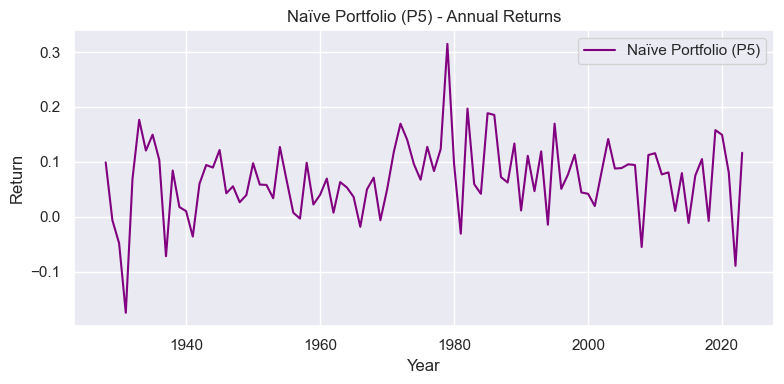

In [76]:
x5 = np.array([0.2, 0, 0.2, 0.2, 0.2, 0.2])
portfolios['P5'] = assets.dot(x5)
mean_return_p5 = Arithmetic_Mean(portfolios['P5'])
risk_p5 = Volatility(portfolios['P5'])
sharpe_ratio_p5 = Sharpe_Ratio(portfolios['P5'])
print("Naïve Portfolio (P5):")
print(f"Mean Return: {mean_return_p5:.2%}")
print(f"Risk (Standard Deviation): {risk_p5:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_p5:.2f}")
plt.figure(figsize=(8, 4))
plt.plot(portfolios['P5'].index, portfolios['P5'], label='Naïve Portfolio (P5)', color='purple')
plt.title("Naïve Portfolio (P5) - Annual Returns")
plt.xlabel("Year")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### ✅ Pros
- **Diversified Allocation**: Spreads exposure evenly across five different asset classes, reducing single-source risk.
- **Low Volatility**: With a standard deviation of **6.86%**, it maintains lower portfolio risk than equity-heavy strategies.
- **Balanced Risk-Adjusted Return**: Achieves a Sharpe Ratio of **0.51**, indicating reasonable efficiency without complex modeling.
- **Simple Implementation**: Easy to construct and manage without relying on forecasts, models, or historical optimization.

### ⚠️ Cons
- **Lower Return Potential**: Mean return of **6.89%** may underperform during strong bull markets compared to equity-tilted portfolios.
- **Static Allocation**: Lacks macroeconomic insight or responsiveness to changing market conditions.
- **No Cash Component**: Omits T-Bills, reducing liquidity and defensive characteristics during downturns.
- **Maintenance Required**: Equal weights must be rebalanced periodically to preserve intended exposure.

### Minimum Variance Portfolio

Custom Minimum-Variance Portfolio (P6):
Mean Return: 9.27%
Risk (Standard Deviation): 12.29%
Sharpe Ratio: 0.48


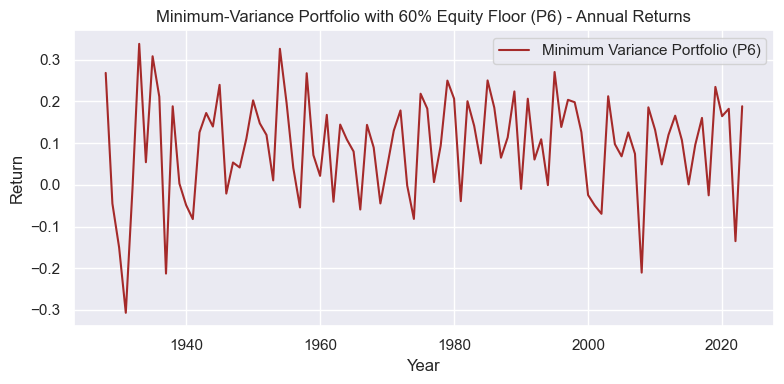

In [79]:
def calc_port_vol(x, rs):
    return rs.dot(x).std()

def calc_x6(rs, x0, window):
    x6 = []
    for r in rs.shift().rolling(window):
        if r.shape[0] < window:
            x6.append(x0)
        else:
            res = sco.minimize(
                fun=calc_port_vol,
                args=(r,),
                x0=x0,
                bounds=((0.6, 1), (0, 0), (0.4, 1), (0.4, 1), (0.4, 1), (0.4, 1)),
                constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1},)
            )
            if res['success']:
                x6.append(res['x'])
            else:
                x6.append(x0)
    return pd.DataFrame(data=x6, index=rs.index, columns=rs.columns)

x6_0 = np.array([0.6, 0, 0.1, 0.1, 0.1, 0.1])
x6 = assets.pipe(calc_x6, x0=x6_0, window=10)

portfolios['P6'] = assets.mul(x6).sum(axis=1)

mean_return_p6 = Arithmetic_Mean(portfolios['P6'])
risk_p6 = Volatility(portfolios['P6'])
sharpe_ratio_p6 = Sharpe_Ratio(portfolios['P6'])

print("Custom Minimum-Variance Portfolio (P6):")
print(f"Mean Return: {mean_return_p6:.2%}")
print(f"Risk (Standard Deviation): {risk_p6:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio_p6:.2f}")

plt.figure(figsize=(8, 4))
plt.plot(portfolios['P6'].index, portfolios['P6'], label='Minimum Variance Portfolio (P6)', color='brown')
plt.title("Minimum-Variance Portfolio with 60% Equity Floor (P6) - Annual Returns")
plt.xlabel("Year")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### ✅ Pros

**- Risk-Aware Design**  
Built using a **rolling 10-year window**, this portfolio minimizes volatility while maintaining a **60% equity floor**, ensuring growth potential without excessive risk.

**- Out-of-Sample Robustness**  
Avoids overfitting by relying only on past volatility (not mean returns). This enhances **out-of-sample performance**, a common flaw in traditional mean-variance models.

**- Adaptive Allocation**  
Weights adjust over time based on historical risk trends, offering a **dynamic structure** that better responds to changing market conditions than static portfolios.

**- Strong Total Return**  
With a **mean return of 9.27%** and **Sharpe Ratio of 0.48**, it outperforms more naïve diversification approaches, especially during volatile markets.


### ⚠️ Cons

**- Higher Volatility than Defensive Portfolios**  
At **12.29% standard deviation**, it carries more risk than fixed-income-heavy portfolios like the Permanent or All-Seasons portfolios.

**- Computational Complexity**  
Requires **rolling optimizations**, making it less accessible for retail investors without tools like Python and historical data pipelines.

**- Equity Concentration Constraint**  
The 60% equity floor while helpful for growth limits further diversification and may **reduce downside protection** during equity drawdowns.

**- No Forecasting of Returns**  
While avoiding unreliable mean-return estimates is intentional, this approach also **ignores alpha opportunities** that other models might pursue.

In [81]:
portfolios.pipe(calc_stats, stats=stats)

Portfolio,P1,P2,P3,P4,P5,P6
Statistic,,,,,,
Arithmetic_Mean,0.12,0.09,0.07,0.07,0.07,0.09
Geometric_Mean,0.10,0.08,0.06,0.07,0.07,0.09
Volatility,0.20,0.12,0.07,0.08,0.07,0.12
Sharpe_Ratio,0.42,0.45,0.46,0.47,0.51,0.48
CAPM_Beta,0.97,0.59,0.23,0.30,0.24,0.60
Max_Drawdown,0.65,0.40,0.19,0.20,0.22,0.44


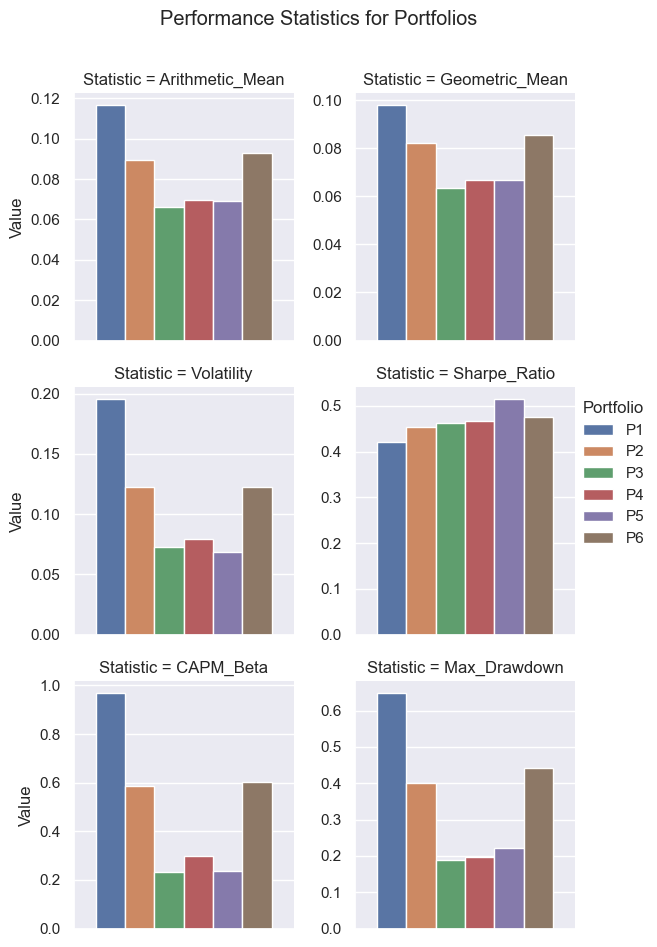

In [82]:
portfolios.pipe(plot_stats, stats=stats)

In [83]:
portfolios.corr()

Portfolio,P1,P2,P3,P4,P5,P6
Portfolio,,,,,,
P1,1.00,0.97,0.62,0.75,0.65,0.98
P2,0.97,1.00,0.67,0.89,0.72,0.97
P3,0.62,0.67,1.00,0.75,0.97,0.76
P4,0.75,0.89,0.75,1.00,0.80,0.82
P5,0.65,0.72,0.97,0.80,1.00,0.80
P6,0.98,0.97,0.76,0.82,0.80,1.00


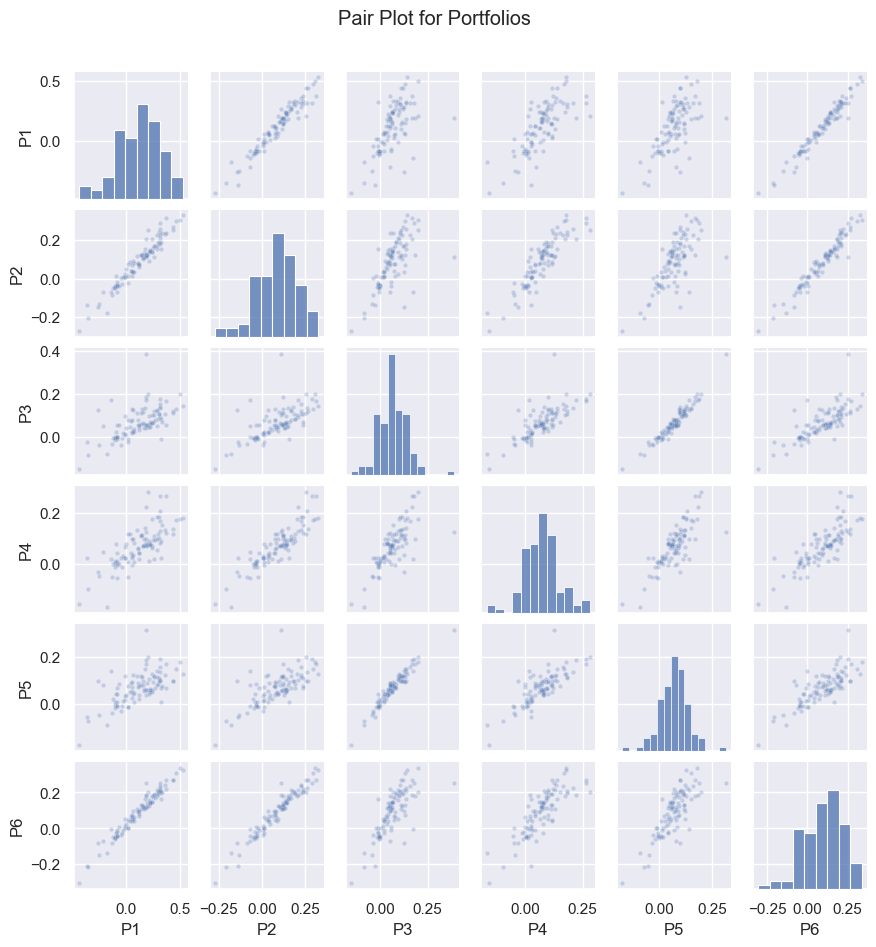

In [84]:
portfolios.pipe(plot_pairs)

The diversified portfolios are less volatile than P1 (All Equity) but might have difficulty meeting retirement goals, even when P1 does poorly!

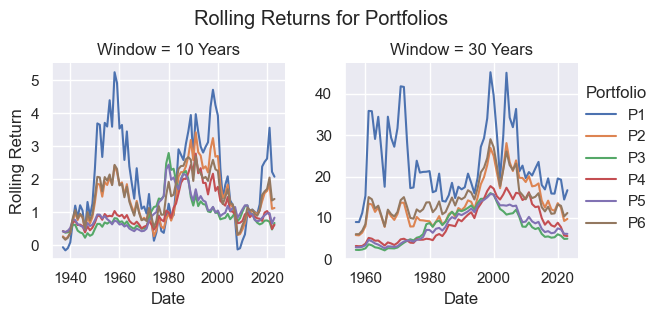

In [86]:
portfolios.pipe(plot_rr, windows=[10, 30])

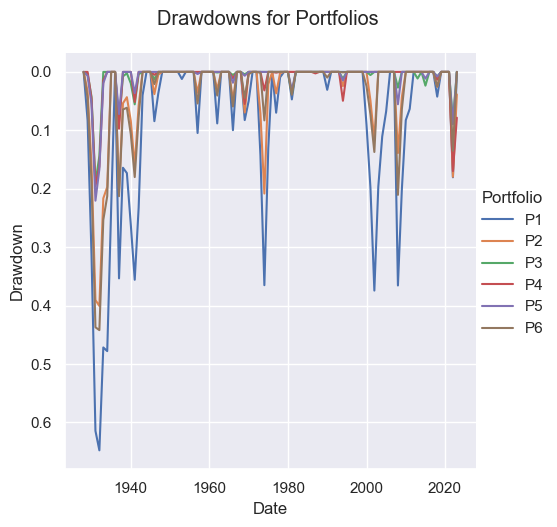

In [87]:
portfolios.pipe(plot_dd)

Through the power of diversification, all these portfolios are effectively on the efficient frontier using the full sample.

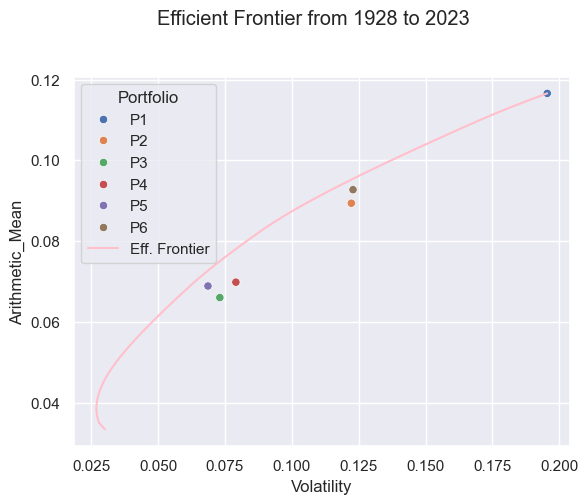

In [89]:
assets.pipe(plot_ef, dots=portfolios)

When Harry Browne proposed P3 (Permanent), it was effectively on the efficient frontier, largely because of gold's outperformance during the 1970s.
P3 is still a good portfolio, albeit with the lowest returns because of its low weight on equity, which explains why people still talk about it!

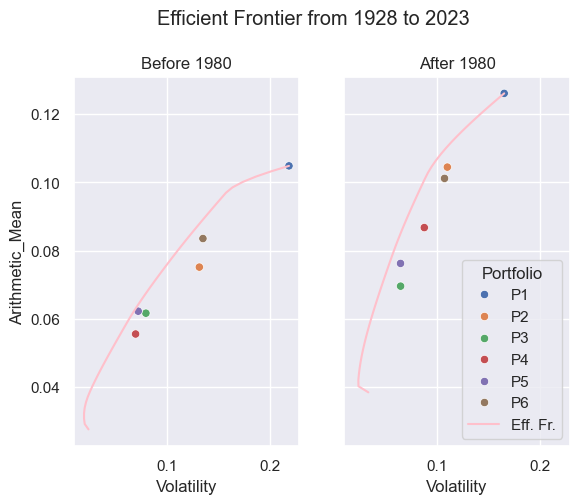

In [91]:
assets.pipe(plot_ef, dots=portfolios, split=1980)

**While P4 (All Seasons) appears well-diversified and thoughtfully constructed, the limited 9-year post-2014 window is likely too short to reliably assess its out-of-sample performance.
Additionally, the absence of 30-year Treasury data may lead to an underestimation of both return and the true risk-return profile for P3 (Permanent) and P4 (All Seasons), since long-duration bonds are critical components in both strategies.**

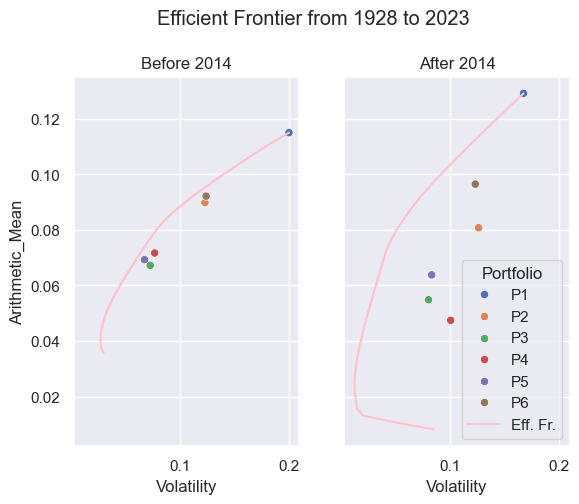

In [93]:
assets.pipe(plot_ef, dots=portfolios, split=2014)

In [94]:
assets.groupby(lambda x: f'{x // 10}0s').agg(['mean', 'std'])

Asset S&P 500      T-Bill      T-Bond      Baa Bond      Real Estate       \
         mean  std   mean  std   mean  std     mean  std        mean  std   
Date                                                                        
1920s    0.18 0.37   0.03 0.00   0.03 0.02     0.03 0.00       -0.00 0.03   
1930s    0.04 0.34   0.01 0.01   0.04 0.03     0.08 0.12       -0.01 0.06   
1940s    0.10 0.17   0.00 0.00   0.03 0.02     0.05 0.03        0.09 0.10   
1950s    0.21 0.20   0.02 0.01   0.01 0.03     0.02 0.03        0.03 0.04   
1960s    0.09 0.14   0.04 0.01   0.03 0.04     0.03 0.04        0.02 0.02   
1970s    0.08 0.19   0.06 0.02   0.06 0.06     0.07 0.07        0.09 0.05   
1980s    0.18 0.12   0.09 0.03   0.13 0.13     0.14 0.10        0.06 0.03   
1990s    0.19 0.14   0.05 0.01   0.08 0.10     0.10 0.08        0.03 0.03   
2000s    0.01 0.21   0.03 0.02   0.07 0.09     0.08 0.06        0.04 0.09   
2010s    0.14 0.12   0.01 0.01   0.04 0.07     0.07 0.07        0.04 0.05   
2020s    0.14 0.22   0.02 0.02  -0.02 0.12     0.01 0.12        0.10 0.06   

Asset  Gold       
       mean  std  
Date              
1920s -0.00 0.00  
1930s  0.06 0.15  
1940s -0.01 0.03  
1950s  0.01 0.03  
1960s  0.02 0.04  
1970s  0.35 0.45  
1980s -0.01 0.20  
1990s -0.03 0.10  
2000s  0.15 0.13  
2010s  0.05 0.16  
2020s  0.09 0.13

### 💡 Insights

- **Diversification improves risk-adjusted returns**  
  Naïve and Permanent portfolios showed stable performance with lower volatility.

- **Optimization adds value**  
  P6 outperformed others in terms of return while maintaining a strong Sharpe ratio, thanks to rolling minimum-variance logic with a 60% equity floor.

- **Historical anomalies matter**  
  Gold’s behavior changed post-1971, and the absence of 30-year Treasury data may understate the performance of P3 and P4.

- **Sharpe Ratio ≠ Best Choice Always**  
  All-Seasons (P4) had the highest Sharpe, but lower total returns than P6 or P1, showing tradeoffs based on investor risk preference.

---

### ✅ Conclusion

This model demonstrates the **power of portfolio diversification and quantitative optimization** in long-term investing. While all-equity portfolios deliver higher returns, they come at the cost of significant volatility. In contrast, the **Custom Minimum-Variance Portfolio (P6)** stands out as a **robust and risk-efficient choice**, especially for conservative or retirement-focused investors.

In [104]:
import pickle
import pandas as pd

stats_dict = {}
for i in range(1, 7):
    port_name = f'P{i}'
    stats_df = portfolios[[port_name]].pipe(calc_stats, stats=stats)
    stats_dict[port_name] = stats_df.squeeze().to_dict()

detailed_stats = {}
for i in range(1, 7):
    port_name = f'P{i}'
    stats_df = portfolios[[port_name]].pipe(calc_stats, stats=stats)
    detailed_stats[port_name] = {
        'stats': stats_df,
        'returns': portfolios[port_name]
    }

efficient_frontier_df = calc_ef(assets, n=50)

dashboard_data = {
    'assets': assets,
    'portfolios': portfolios,
    'stats': stats_dict,
    'detailed_stats': detailed_stats,
    'correlation_matrix': portfolios.corr(),
    'rolling_returns': {
        '10_year': portfolios.pipe(calc_rr, window=10),
        '30_year': portfolios.pipe(calc_rr, window=30)
    },
    'drawdowns': portfolios.pipe(calc_dd),
    'efficient_frontier': efficient_frontier_df,
    'insights': {
        'summary': "Diversification improves risk-adjusted returns. P6 has the best Sharpe ratio.",
        'commentary': [
            "Gold's post-1971 anomaly may skew historical comparisons.",
            "Sharpe ratio alone is not ideal for all investors.",
            "The minimum-variance portfolio is a robust option for risk-sensitive allocations."
        ]
    }
}

with open("portfolio_dashboard_data.pkl", "wb") as f:
    pickle.dump(dashboard_data, f)
print("✅ Pickle file 'portfolio_dashboard_data.pkl' has been created.")

✅ Pickle file 'portfolio_dashboard_data.pkl' has been created.
